# Diederske grupe 

Študiramo (2d) upodobitve diederskih grup
 $D_{2n} = <r, s \mid r^n = s^2 = (rs)^2 = 1>$.

In [31]:
from gofi.ode.dihedral.loss import *
import numpy as np
n=5

irr_loss = IrreducibilityLoss(n)
unit_loss = UnitaryLoss()
rel_loss = RelationLoss(n)



S0 = np.array([[0,1],[1,0]])
R0 = np.array([[np.cos(2*np.pi/5), -np.sin(2*np.pi/5)],
               [np.sin(2*np.pi/5), np.cos(2*np.pi/5)]])

### $d\mathcal L_{\text{rel}}$
$$
 \mathcal L_{\text{rel}} = 
  \frac{1}{3}(||S^2 - I ||^2_F + ||R^n -I||^2_F + || (RS)^2 - I ||^2_F),
$$
kjer je $R=\rho(r)$ in $S = \rho(s)$.

Velja
$$
\frac{d}{dX}||X^n-I||_F^2=2\left (\sum\limits_{i=0}^{n-1}X^{n-i-1}(X^T)^n X^i  -nX^{n-1}  \right )^T 
$$
Za lažje računanje uvedemo
$$
Q(X,n) = \sum\limits_{i=0}^{n-1}X^{n-i-1}(X^T)^n X^i -nX^{n-1}
$$
Velja še 
$$
\frac{d}{dR}||(RS)^2 - I||_F^2 = 2\left(SRS(RS)^{T^2} + S(RS)^{T^2} RS - 2SRS        \right ) ^T
$$ 
in 
$$
\frac{d}{dR}||(RS)^2 - I||_F^2 = 2 \left (RS (RS)^{T^2} R + (RS)^{T^2}RSR - 2RSR                 \right) ^T
$$


In [189]:
# definiraj grad_L
import numpy as np

# from numpy.linalg import matrix_power as pow
from numpy.linalg import norm


def pow(A, n):
    dim = A.shape[0]
    X = np.eye(dim)
    for i in range(n):
        X = X @ A
    return X

def norm_square_RS_minus_I_by_R(R, S):
    """
    Returns 2(  SRS(RS)^{T^2} + S(RS)^{T^2} RS - 2SRS) ^T
    """
    RST = pow((R @ S).transpose(), 2)
    ans = S @ R @ S @ RST + S @ RST @ R @ S - 2 * S @ R @ S
    return 2 * ans.transpose()

def norm_square_RS_minus_I_by_S(R, S):
    """
    Returns  2  (RS (RS)^{T^2} R + (RS)^{T^2}RSR - 2RSR) ^T
    """
    RST = pow((R @ S).transpose(), 2)
    ans = R @ S @ RST @ R + RST @ R @ S @ R - 2 * R @ S @ R
    return 2 * ans.transpose()

def Q(X, n):
    """
    Returns 1/2 * (  d/dX (||X^n - I||^2) )^T
    """
    dim = X.shape[0]
    ans = np.zeros(X.shape)
    for i in range(n):
        ans += pow(X, n - i - 1) @ pow(X.transpose(), n) @ pow(X, i)
    ans -= n * pow(X, n-1)
    return ans


def d_Lrel_dR(R, S, n):
    return (1 / 3) *( 2 * Q(R, n).transpose() +   norm_square_RS_minus_I_by_R(R, S) )


def d_Lrel_dS(R, S):
    return (1 / 3) * (2 * Q(S, 2).transpose() + norm_square_RS_minus_I_by_S(R, S))


def Lrel(R, S, n):
    dim = R.shape[0]
    eye = np.eye(dim)
    return (1 / 3) * (norm(pow(R,n) - eye, ord='fro')**2 
                    + norm(pow(S,2) - eye, ord='fro')**2
                    + norm(pow(R@S,2) - eye, ord='fro') **2)

### $d \mathcal L_{\text{irr}}$
$$
 \mathcal L_{\text{irr}} =
 (|\chi|-1)^2
 \\= \left( 
    (\frac{1}{2n} \sum \limits_{i=0}^{n-1} ( |\text{tr}(R^i)|^2 + |\text{tr}(R^iS)|^2 )  ) -1
    \right )^2,
$$
kjer je $R=\rho(r)$, $S = \rho(s)$ in $|\chi| = \frac{1}{2n} \sum \limits_{i=0}^{n-1} ( |\text{tr}(R^i)|^2 + |\text{tr}(R^iS)|^2 )  )$
Velja
$$
d(|\chi| -1) = d|\chi| = \text{tr}\left((\frac{1}{n} \sum_{i=0}^{n-1} \text{tr}(R^iS)R^i       )dS           \right) +\\
\text{tr}\left((\frac{1}{n} \sum_{i=1}^{n-1} \text{tr}(R^i)iR^{i-1}           )dR  \right)+\\
\text{tr}\left((\frac{1}{n} \sum_{i=1}^{n-1} \text{tr}(R^iS)(\sum_{j=0}^{i-1}  R^{i-j-1}SR^j)         )dR \right)
$$

$$
\frac{d}{dR}(|\chi| -1)^2 =\\ \frac{2}{n}(1 - |\chi|) 
\left (
\sum_{i=1}^{n-1} \text{tr}(R^i)iR^{i-1} + 
\text{tr}(R^iS)(\sum_{j=0}^{i-1}  R^{i-j-1}SR^j)         
\right)^T
$$

$$
\frac{d}{dS}(|\chi| -1)^2 \\= \frac{2}{n}(1 - |\chi|)
 \left (\sum_{i=0}^{n-1} \text{tr}(R^iS)R^i      \right) ^T
$$


In [190]:
def norm_chi(R, S, n):
    ans = 0
    for i in range(n):
        ans += np.abs(np.trace(pow(R, i))) ** 2
        ans += np.abs(np.trace(pow(R, i) @ S)) ** 2
    ans /= 2 * n
    return ans


def Lirr(R, S, n):
    return (norm_chi(R, S, n) - 1) ** 2


def d_Lirr_dR(R, S, n):
    """
    Returns
      2 * (  d/dR (||chi(R,S,n)||^2 - 1) )^T, which is equal to
    2/n(1 - |chi|) 
(
sum_{i=1}^{n-1} tr(R^i)iR^{i-1} + 
tr(R^iS)(sum_{j=0}^{i-1}  R^{i-j-1}SR^j)         
)^T$
    """
    dim = R.shape[0]
    ans = np.zeros((dim, dim))
    for i in range(1, n):
        ans += np.trace(pow(R, i)) * i * pow(R, i - 1)
        ans += np.trace(pow(R, i) @ S) * (sum([pow(R, i - j - 1) @ S @ pow(R, j) for j in range(i)]))
    ans = ans.transpose()
    ans *= 2 * (norm_chi(R, S, n) - 1) / n
    return ans


def d_Lirr_dS(R, S, n):
    """
    Returns 2/n(1 - |chi|)
  (sum_{i=0}^{n-1} tr(R^iS)R^i      ) ^T
    """
    dim = R.shape[0]
    ans = np.zeros((dim, dim))
    for i in range(0, n):
        ans += np.trace( pow(R, i)@S) * pow(R, i)
    ans = ans.transpose()
    ans *= 2 * (norm_chi(R, S, n) -1) / n
    return ans

### $\mathcal L_{unitary}$
$$
\mathcal L_{unitary} = \frac{1}{|S|} \sum_{s \in S} ||\rho(s) \rho(s)^H - I||
$$
$$
\frac{d}{dS}||SS^H - I||_F^2= \dotsc = 4(SS^TS -S)
$$

In [191]:
def Lunitary(R, S):
    """
    Returns 1/2 * (||R^T R - I||^2 + ||S^T S - I||^2)
    """
    dim = R.shape[0]
    eye = np.eye(dim)
    return (1 / 2) * (norm(R.transpose() @ R - eye, ord='fro')**2 + norm(S.transpose() @ S - eye, ord='fro')**2)
def unitary_norm(X):
    """
    Returns d/dx (||X^T X - I||^2)
    """ 
    return 4 * (X @ X.transpose() @ X - X )

def d_Lunitary_dR(R):
    """
    Returns 2 * (d/dR (||R^T R - I||^2))^T
    """
    return 0.5 *unitary_norm(R)
def d_Lunitary_dS(S):
    """
    Returns 2 * (d/dS (||S^T S - I||^2))^T
    """
    return 0.5 * unitary_norm(S)


ModuleNotFoundError: No module named 'dihedral'

(np.float64(0.0),
 np.float64(4.330819136826611e-32),
 array([[ 0., -0.],
        [ 0.,  0.]]),
 array([[ 0., -0.],
        [ 0.,  0.]]),
 array([[ 6.66133815e-16,  1.48029737e-16],
        [-7.40148683e-16,  6.66133815e-16]]),
 array([[-7.03923228e-17, -1.48029737e-16],
        [-1.48029737e-16,  2.82711640e-17]]),
 np.float64(1.2410857013328928e-32),
 array([[-1.11022302e-16,  2.22044605e-16],
        [-2.22044605e-16,  0.00000000e+00]]),
 array([[0., 0.],
        [0., 0.]]))

In [196]:
# poženi solve_ivp
from scipy.integrate import solve_ivp
n= 5
dim = 2
t_max = 1




def neg_grad(t, z):
    R = np.reshape(z[:len(z)//2], (dim, dim))
    S = np.reshape(z[len(z)//2:], (dim, dim))

    dR = - d_Lrel_dR(R,S, n) - d_Lirr_dR(R,S, n) - d_Lunitary_dR(R)
    dS = - d_Lrel_dS(R, S) - d_Lirr_dS(R, S, n) - d_Lunitary_dS(S)

    dR = dR.flatten()
    dS =  dS.flatten()
    return np.concatenate((dR, dS), axis=None)

def convergence_event(t, z, eps):
    R = np.reshape(z[:len(z)//2], (dim, dim))
    S = np.reshape(z[len(z)//2:], (dim, dim))
    loss = Lirr(R, S, n) + Lrel(R,S,n) + Lunitary(R,S)
    return loss - eps
convergence_event.terminal = True
convergence_event.direction = -1   # or 0 if you want it to trigger in any direction

def get_convergence_event(eps):
    def g(t, z):
        return convergence_event(t, z, eps)
    return g



R0= np.random.rand(2,2)*10
#S0= np.random.rand(2,2)*10

S0 = np.array([[0,1],[1,0]])
R0 = np.array([[np.cos(2*np.pi/n), -np.sin(2*np.pi/n)],
               [np.sin(2*np.pi/n), np.cos(2*np.pi/n)]])
# S0 =S0 + np.random.normal(scale=0.1, size=(2,2))
# R0 =R0 + np.random.normal(scale=0.1, size=(2,2))

S0 = S0.flatten()
R0 = R0.flatten()

P0 = np.concatenate((R0, S0), axis=None)


In [198]:
solution = solve_ivp(neg_grad, (0, 10), P0,     events=get_convergence_event(0.001))#, method='Radau')


/tmp/ipykernel_235234/33529845.py:12: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/33529845.py:12: RuntimeWarning:

invalid value encountered in matmul

/tmp/ipykernel_235234/33529845.py:19: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/33529845.py:20: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/33529845.py:20: RuntimeWarning:

invalid value encountered in matmul

/tmp/ipykernel_235234/1293049682.py:28: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/1293049682.py:27: RuntimeWarning:

overflow encountered in multiply

/tmp/ipykernel_235234/1293049682.py:28: RuntimeWarning:

invalid value encountered in matmul

/tmp/ipykernel_235234/1293049682.py:5: RuntimeWarning:

overflow encountered in scalar power

/tmp/ipykernel_235234/1293049682.py:5: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/1293049682.py:4: RuntimeWarning:

overflow encountered in scalar power

/tmp/

In [199]:
def get_matrices(solution_y, index):
      z = solution_y.transpose()[index]
      R = np.reshape(z[:len(z)//2], (dim, dim))
      S = np.reshape(z[len(z)//2:], (dim, dim))
      return R, S
def get_characters(solution_y):
    solutions = solution_y.transpose()
    char_R = []
    char_S=[]
    for z in solutions:
            R = np.reshape(z[:len(z)//2], (dim, dim))
            S = np.reshape(z[len(z)//2:], (dim, dim))
            char_R.append(np.trace(R))
            char_S.append(np.trace(S))

    return char_R, char_S

charR, charS = get_characters(solution.y)

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_235234/33529845.py:12: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/33529845.py:38: RuntimeWarning:

invalid value encountered in matmul

/tmp/ipykernel_235234/33529845.py:20: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/33529845.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_235234/1293049682.py:28: RuntimeWarning:

overflow encountered in multiply

/tmp/ipykernel_235234/1293049682.py:27: RuntimeWarning:

overflow encountered in multiply

/tmp/ipykernel_235234/1293049682.py:28: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/1293049682.py:28: RuntimeWarning:

invalid value encountered in matmul

/tmp/ipykernel_235234/1293049682.py:5: RuntimeWarning:

overflow encountered in scalar power

/tmp/ipykernel_235234/1293049682.py:4: RuntimeWarning:

overflow encountered in scalar power

/tmp/ipykernel_235234/1293049682.py:5: RuntimeW

Text(0.5, 1.0, 'Trajectory')

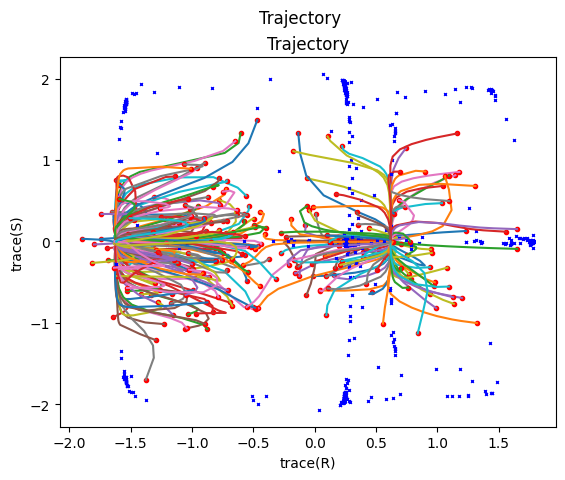

In [251]:
import matplotlib.pyplot as plt
from tqdm import tqdm
S0 = np.array([[0,1],[1,0]])
R0 = np.array([[np.cos(2*np.pi/3), -np.sin(2*np.pi/3)],
               [np.sin(2*np.pi/3), np.cos(2*np.pi/3)]])
fig, axs = plt.subplots(1)
fig.suptitle(f'Trajectory')

t_max=1
sample_size = 1000


n_diverges=0

for _ in tqdm(range(sample_size), total = sample_size):
    P0 = 2 * np.random.rand((8)) - 1
   # print(P0)
    solution = solve_ivp(neg_grad, (0, t_max), P0, events=get_convergence_event(0.001))#, method='Radau')

    # get final matrices
    R, S = get_matrices(solution.y, -1)
    loss = Lirr(R, S, n) + Lrel(R,S,n) + Lunitary(R,S)
    if loss > 0.1:
        #print('loss', loss, ' for initial parameters ', P0)
        n_diverges += 1
        # plot starting params 
        charR = np.trace(R)
        charS = np.trace(S)
        axs.plot(charR, charS, 'xb', markersize=2)
        continue

    charR, charS = get_characters(solution.y)



    # plot initial step
    axs.plot(charR[0], charS[0], 'ro', label='Initial point', markersize=3)
   # axs.plot(1, 0, 'go', label='rho_k', markersize=2)

    axs.plot(charR, charS)

#for index, (cR, cS) in enumerate(zip(charR, charS)):
#    axs.plot(cR, cS, color=cmap(cmap_norm(solution.t[index])), lw=2)

axs.set_xlabel('trace(R)')
axs.set_ylabel('trace(S)')
#axs.legend()
axs.set_title('Trajectory')







In [201]:
print("Število začetnih parametrov, ki ne konvergirajo k pravi upodobitvi: ", n_diverges)
print("P(R0, S0 konvergira k upodobitvi) ≃ ", (sample_size - n_diverges)/sample_size)

Število začetnih parametrov, ki ne konvergirajo k pravi upodobitvi:  80
P(R0, S0 konvergira k upodobitvi) ≃  0.2


In [ ]:
print("Pričakovane sledi za R:")
for i in range(0, n):
    print(np.cos(2 * np.pi * i / n))

Pričakovane sledi za R:
1.0
6.123233995736766e-17
-1.0
-1.8369701987210297e-16


In [ ]:
np.cos(2*np.pi/3), -np.cos(2*2*np.pi/3)

(np.float64(-0.4999999999999998), np.float64(0.5000000000000004))

In [ ]:
solution.y[0][0], solution.y[1][0]

(np.float64(-0.3513779293247483), np.float64(-0.10645273591295679))

### Loss function and grids
Naj bosta 
$$
R = \begin{bmatrix} a & b \\ c & d
\end{bmatrix}, \quad 
S = \begin{bmatrix} x & y\\ z & w
\end{bmatrix}
$$ 
realni matriki. Za prikaz rezultatov preizušam različne metode projekcij.

### $a = d$, $x = w$
Omejimo se na matrike oblike $R = \begin{bmatrix} a & b \\ c & a
\end{bmatrix}, \quad 
S = \begin{bmatrix} x & y\\ z & x
\end{bmatrix}$. Za fiske $b, c, y, z$ jih parametriziram s karakterjem.

In [ ]:
def loss(R, S, n):
    return Lirr(R, S, n) + Lrel(R, S, n)

def char_to_semi_diag(char, b, c):
    a = char /2
    return np.array([[a, b], [c, a]])

### Ortogonala grupa - parametrizacija $p \colon R \to O(2)$

Da rezultate obeh matrik spravim na en graf, lahko uporabim parametrizacijo 
$$
p \colon (-1,1) \to O(2)  \\
x \mapsto \begin{bmatrix}
x & -\sqrt{1 - x^2} \\
\sqrt{1 - x^2} & x 
\end{bmatrix}.
$$.
Definiram $R = R(x) = p(x)$ in $S = S(y) = p(y)$.

Velja 
$$
\frac{d}{dx} \mathcal L(R,S) = \text{tr}( {\frac{d\mathcal L}{dR}}^T \frac{dR}{dx}  ) 
$$
in
$$
\frac{d}{dy} \mathcal L(R,S) = \text{tr}( {\frac{d\mathcal L}{dS}}^T \frac{dS}{dy}  ) .
$$
Velja še   $\frac{dR}{dx} =p'(x) = \begin{bmatrix}
1 & (1 - x^2)^{-0.5} \\
-(1 - x^2)^{-0.5} & 1 
\end{bmatrix}.
$

In [ ]:
def p(x):
    y = np.sqrt(1 - x**2)
    return np.array([[x, -y],[y, x]])

def dp(x):
    y = 1/np.sqrt(1 - x**2)
    return np.array([[1, -y], [y, 1]])

def dL_dx(x, y, n):
    """
    Returns dL/dx
    """
    R = p(x)
    S = p(y)
    dL_dR = d_Lrel_dR(R, S, n) + d_Lirr_dR(R, S, n) + d_Lunitary_dR(R)
    dR_dx = dp(x)
    return np.trace(dL_dR.transpose() @ dR_dx)

def dL_dy(x, y, n):
    """
    Returns dL/dy
    """
    R = p(x)
    S = p(y)
    dL_dR = d_Lrel_dS(R, S) + d_Lirr_dS(R, S, n) + d_Lunitary_dS(S)
    dS_dy = dp(y)
    return np.trace(dL_dR.transpose() @ dS_dy)

In [ ]:
# r naj bo parameter za R, s pa za S. 
def neg_grad_param(t, z):
    # collect points
    r, s = z

    return - dL_dx(r, s, n), - dL_dy(r, s, n)

def convergence_event_param(t, z, eps):
    '''Check, if loss < eps'''
    # collect points
    r, s = z
    # convert to matrices
    R = p(r)
    S = p(s)
    # get loss:
    loss = Lirr(R, S, n) + Lrel(R,S,n)
    return loss - eps

convergence_event_param.terminal = True
convergence_event_param.direction = -1   # or 0 if you want it to trigger in any direction

def get_convergence_event_param(eps):
    def g(t, z):
        return convergence_event_param(t, z, eps)
    return g

In [ ]:
import numpy as np
from tqdm import tqdm
# grid settings 
resolution = 10
t_max = 2
min_param = -0.9
max_param = 0.9
# prepare grid
x = np.linspace(min_param, max_param, resolution)
y = np.linspace(min_param, max_param, resolution)
x, y = np.meshgrid(x, y)
solutions = []

grid = np.zeros((resolution, resolution, 1))
# solve gradient flow equation for each pixel
for index, (x0, y0) in tqdm(enumerate(zip(x.flatten(), y.flatten())) , total=resolution ** 2):
    # no limit option:
    # solution = solve_ivp(neg_grad_param, (0, t_max), (x0, y0))
    solution = solve_ivp(neg_grad_param, (0, 100), (x0, y0), events=get_convergence_event_param(0.0001))
    solutions.append(solution)
    
    # color of the pixel is atan2 of final point
    grid[index // resolution][index % resolution] = np.degrees(np.arctan2(solution.y[1][-1], solution.y[0][-1]))



  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_235234/3081689463.py:2: RuntimeWarning:

invalid value encountered in sqrt

/tmp/ipykernel_235234/3081689463.py:6: RuntimeWarning:

invalid value encountered in sqrt

  0%|          | 0/100 [05:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from datetime import datetime
# save info
# np.save(f'grid_D3_O2_{str(datetime.now())}', grid)

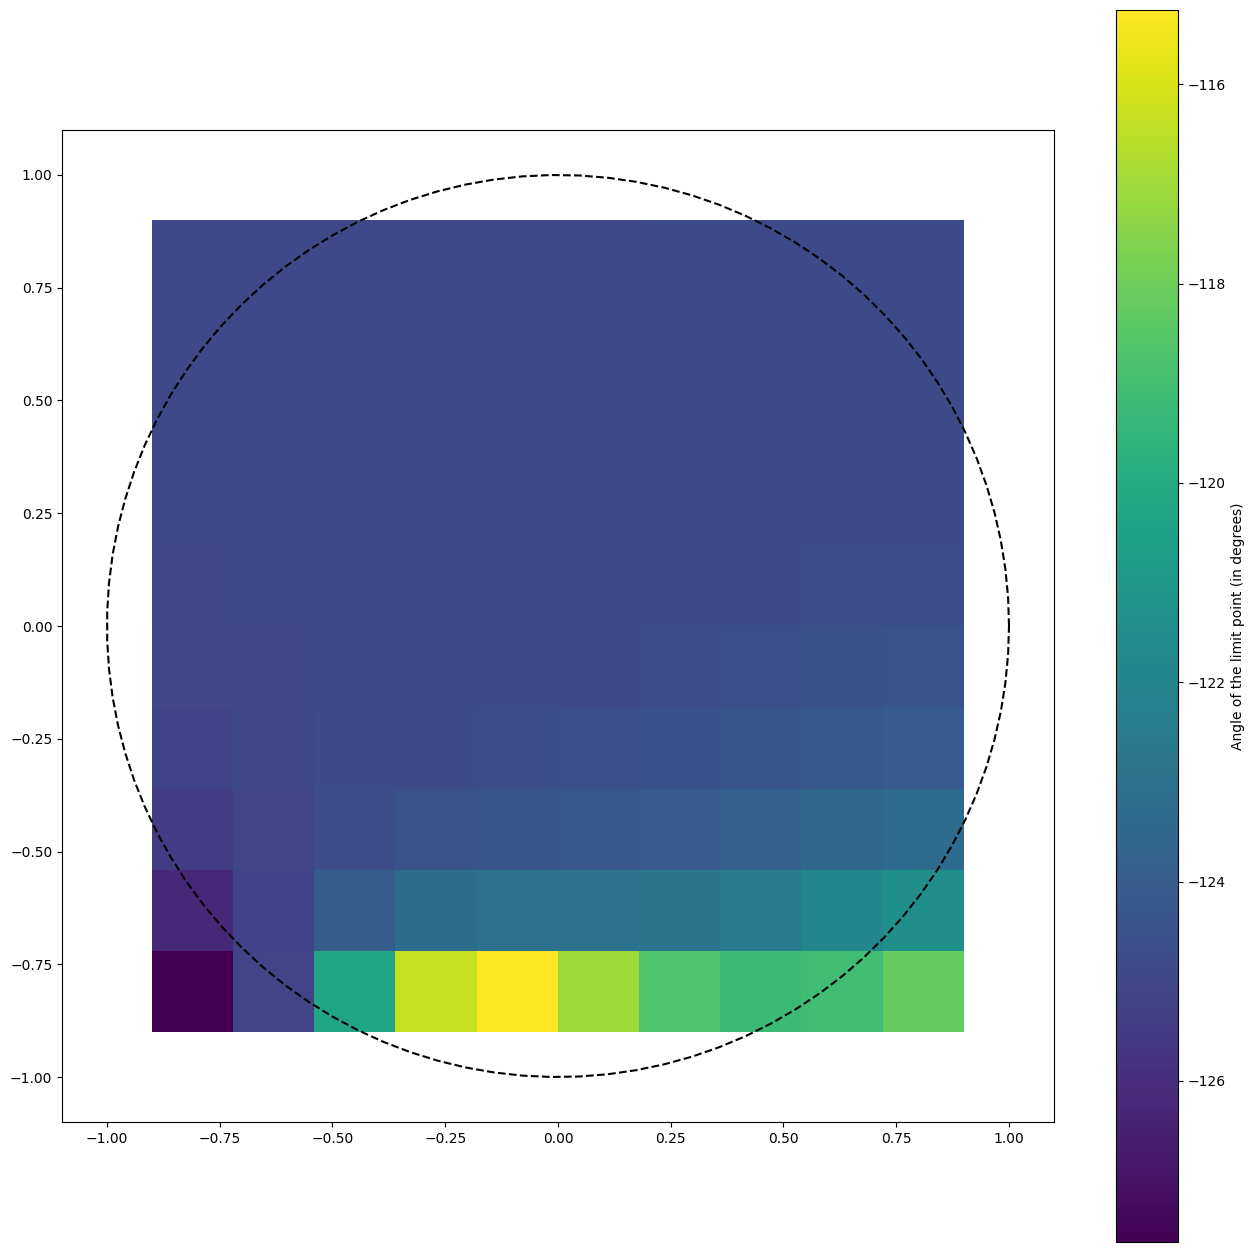

In [ ]:

# plot results
plt.figure(figsize=(16, 16))
# plot the grid
plt.imshow(grid, cmap='viridis', extent=(min_param, max_param, min_param, max_param), origin='lower')

plt.colorbar(label='Angle of the limit point (in degrees)')

# plot the unit circle
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), 'k--', label='Unit Circle')

# save fig
plt.savefig(str('D3_to_O2' + str(datetime.now()) + '.png' ))
plt.show()



# Ortogonalnost karakterjev
Če najdemo eno nerazcepno upodobitev, lahko iščemo novo, ki je pravokotna na staro.
Definiramo
$$
\mathcal O_{R_0, S_0}(R, S) =\left( 
 \frac{1}{2n} \sum_{i=0}^{n-1} \left( \text{tr}(R_0^i)\text{tr}(R^{n-i}) + \text{tr}(R_0^i S_0)\text{tr}(SR^{n-i}) \right)
 \right )^2 = [\chi_{R_0, S_0}, \chi_{R,S}]^2.
$$
Velja 
$$
\frac{d}{dR} \mathcal O_{R_0, S_0}(R, S) = \frac{1}{2n}  [\chi_{R_0, S_0}, \chi_{R,S}]  \sum_{i=0}^{n-1} \left(
 \text{tr}(R_0 ^i) (n-i) R^{n-i-1} + \text{tr}(R_0^iS_0)S(n-i)R^{n-i-1}
 \right)
$$
in 
$$
\frac{d}{dR} \mathcal O_{R_0, S_0}(R, S) = \frac{1}{2n}  [\chi_{R_0, S_0}, \chi_{R,S}]  \sum_{i=0}^{n-1} \left(
\text{tr})(R_0^iS_0)R^{n-i}
 \right).
$$

**Zadeva očitno ne dela.** Mogoče je to pričakovan rezultat. En loss bi res rad ostal pri miru, drug pa mora stran. Ko gre drug stran, se prvi veča. Potem je pa še problem, da je ortogonalni  na nelk način omejen (= v drugih nerazcpenih ne bo večje kot 1)

In [209]:
import torch.nn as nn
class OrtogonalLoss():
    def __init__(self, n : int, R0 : np.array , S0 : np.array):
        """
        Creates loss for ortogonality of characthers. OrtogonalLoss(n, R0, S0)(R, S) is equal to the square of  scalar product 
        between mapping (r -> R0, s -> S0) and (r -> R, s -> S).


        Parameters
        ----------
        n : int 
            Dihedral group D2n number.
        R1 : np.array
            Map of rotation
        S1 : np.array 
            Map of flip
        """
        self.n = n 
        self.R0 = R0 
        self.S0 = S0
    def prod(self, R, S):
        """
        Returns scalar product between mapping rho:(r -> R, s -> S) and rho1:(r -> R1, s -> S1)
        [rho, rho1] = 1/(2n) sum_{g in Dn} tr(rho(g) tr(rho1(g) 
        """
        ans = 0
        for i in range(self.n):
            ans += np.trace(pow(self.R0, i)) * np.trace(pow(R, self. n-i))
            ans += np.trace(pow(self.R0, i) @ self.S0) * np.trace(S @ pow(R, self. n-i))
        ans /= 2 * self.n
        return ans
    def __call__(self, R, S):
        """
        Returns square of  scalar product between mapping rho:(r -> R, s -> S) and rho1:(r -> R1, s -> S1)
        [rho, rho1] = 1/(2n) sum_{g in Dn} tr(rho(g) tr(rho1(g) 
        """ 
        return self.prod(R, S) ** 2

    def dR(self, R, S):
        """
        Returns d/dR(OrtogonalLoss)
        """ 
        ans = np.zeros(R.shape)
        for i in range(self.n):
            ans += np.trace(pow(self.R0, i)) * (self.n - i) * pow(R, self.n - i - 1)
            ans += np.trace(pow(self.R0, i) @ self.S0) * S * (self.n - i) * pow(R, self.n - i - 1)
        ans /= 2 * self.n
        ans *= self.prod(R, S)
        return ans  
    def dS(self,  R, S):
        """
        Returns d/dS(OrtogonalLoss)
        """ 
        ans = np.zeros(S.shape)
        for i in range(self.n):
            ans += np.trace(pow(self.R0, i) @ self.S0) *  pow(R, self.n - i)
        ans /= 2 * self.n
        ans *= self.prod(R, S)
        return ans


        

        

In [234]:
n = 5
S0 = np.array([[0,1],[1,0]])
R0 = np.array([[np.cos(2*np.pi/5), -np.sin(2*np.pi/5)],
               [np.sin(2*np.pi/5), np.cos(2*np.pi/5)]])

S1 = np.array([[0,1],[1,0]])
R1 = np.array([[np.cos(2*np.pi*2/5), -np.sin(2*np.pi*2/5)],
               [np.sin(2*np.pi*2/5), np.cos(2*np.pi*2/5)]])

ort = OrtogonalLoss(n, R0, S0)
for (R, S) in [(R0, S0), (R1, S1)]:
    print("loss : ", ort(R, S),"dR: ", ort.dR(R, S),"dS: ", ort.dS(R, S))

loss :  1.0 dR:  [[ 0.46352549  1.68945033]
 [-1.68945033  0.46352549]] dS:  [[ 3.43077782e-18 -1.05588484e-17]
 [ 1.05588484e-17  3.43077782e-18]]
loss :  4.930380657631325e-34 dR:  [[ 1.24126708e-17 -1.80366664e-18]
 [ 1.80366664e-18  1.24126708e-17]] dS:  [[ 1.99438087e-34  1.44900252e-34]
 [-1.44900252e-34  1.99438087e-34]]


In [236]:
Lirr(R0, S0, n)

np.float64(0.0)

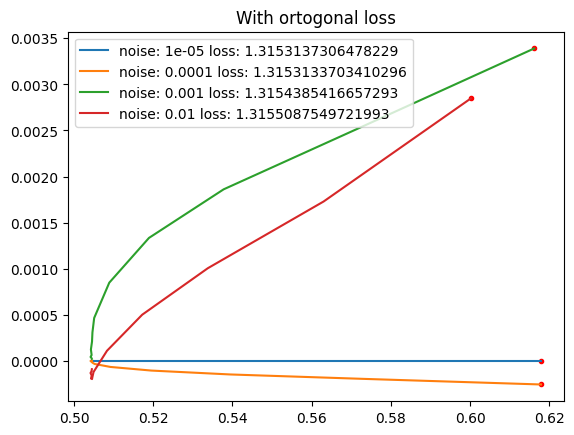

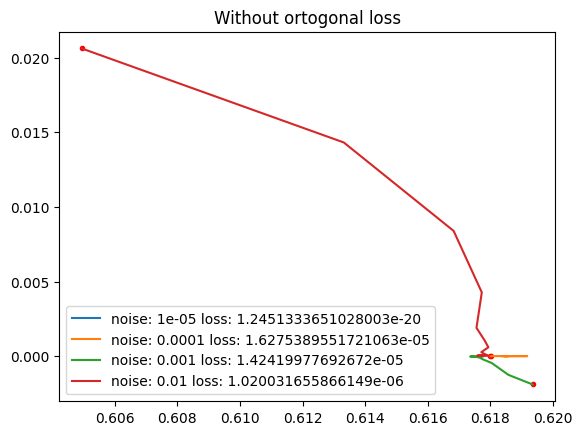

In [249]:


def neg_grad_with_ort(t, z):
    R = np.reshape(z[:len(z)//2], (dim, dim))
    S = np.reshape(z[len(z)//2:], (dim, dim))

    dR = - d_Lrel_dR(R,S, n) - d_Lirr_dR(R,S, n) - d_Lunitary_dR(R) - ort.dR(R, S)
    dS = - d_Lrel_dS(R, S) - d_Lirr_dS(R, S, n) - d_Lunitary_dS(S) - ort.dS(R, S)

    dR = dR.flatten()
    dS =  dS.flatten()
    return np.concatenate((dR, dS), axis=None)
def neg_grad(t, z):
    R = np.reshape(z[:len(z)//2], (dim, dim))
    S = np.reshape(z[len(z)//2:], (dim, dim))

    dR = - d_Lrel_dR(R,S, n) - d_Lirr_dR(R,S, n) - d_Lunitary_dR(R) 
    dS = - d_Lrel_dS(R, S) - d_Lirr_dS(R, S, n) - d_Lunitary_dS(S) 

    dR = dR.flatten()
    dS =  dS.flatten()
    return np.concatenate((dR, dS), axis=None)

sample_size = 4
for i in range(sample_size):

    P0 = np.concatenate((R0.flatten(), S0.flatten()), axis=None)
    # add bigger and bigger noise
    if i  > 0:
        P0 += np.random.normal(0, 10**(i-1 - sample_size), size=(8))

    # with ort -----------------------------------------------------------------
    solution = solve_ivp(neg_grad_with_ort, (0, 1), P0,     events=get_convergence_event(0.001))

    charR, charS = get_characters(solution.y)
    plt.plot(charR[0], charS[0], 'ro', markersize=3)
    
    R, S = get_matrices(solution.y, -1)
    loss = Lirr(R, S, n) + Lrel(R,S,n) + Lunitary(R,S) + ort(R, S)

    plt.plot(charR, charS,label="noise: "+ str(10**(i-1 - sample_size)) + " loss: " + str(loss))

   
    # get R, S 
   
   # print(f"Loss of  {i}-th sample: ", "Irr: ",Lirr(R, S, n), "Rel: ", Lrel(R,S,n), "Unitary: ", Lunitary(R,S) ,"Ort: ", ort(R,S))
plt.legend()
plt.title("With ortogonal loss")
plt.show()
for i in range(sample_size):

    P0 = np.concatenate((R0.flatten(), S0.flatten()), axis=None)
    # add bigger and bigger noise
    if i  > 0:
        P0 += np.random.normal(0, 10**(i-1 - sample_size), size=(8))
    solution = solve_ivp(neg_grad, (0, 1), P0,     events=get_convergence_event(0.001))

    charR, charS = get_characters(solution.y)
    plt.plot(charR[0], charS[0], 'ro', markersize=3)
    
    R, S = get_matrices(solution.y, -1)
    loss = Lirr(R, S, n) + Lrel(R,S,n) + Lunitary(R,S) 

    plt.plot(charR, charS,label="noise: "+  str(10**(i-1 - sample_size))+ " loss: " + str(loss))
   
    # get R, S 
   
   # print(f"Loss of  {i}-th sample: ", "Irr: ",Lirr(R, S, n), "Rel: ", Lrel(R,S,n), "Unitary: ", Lunitary(R,S) ,"Ort: ", ort(R,S))
plt.legend()
plt.title("Without ortogonal loss")
plt.show()

/tmp/ipykernel_235234/33529845.py:38: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/33529845.py:38: RuntimeWarning:

invalid value encountered in matmul

/tmp/ipykernel_235234/33529845.py:20: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/1293049682.py:28: RuntimeWarning:

overflow encountered in multiply

/tmp/ipykernel_235234/1293049682.py:27: RuntimeWarning:

overflow encountered in multiply

/tmp/ipykernel_235234/1293049682.py:5: RuntimeWarning:

overflow encountered in scalar power

/tmp/ipykernel_235234/1293049682.py:4: RuntimeWarning:

overflow encountered in scalar power

/tmp/ipykernel_235234/3349236259.py:48: RuntimeWarning:

overflow encountered in multiply

/tmp/ipykernel_235234/33529845.py:28: RuntimeWarning:

overflow encountered in matmul

/tmp/ipykernel_235234/1293049682.py:42: RuntimeWarning:

overflow encountered in multiply

/tmp/ipykernel_235234/1293049682.py:30: RuntimeWarning:

overflow encountered in multiply

/tmp

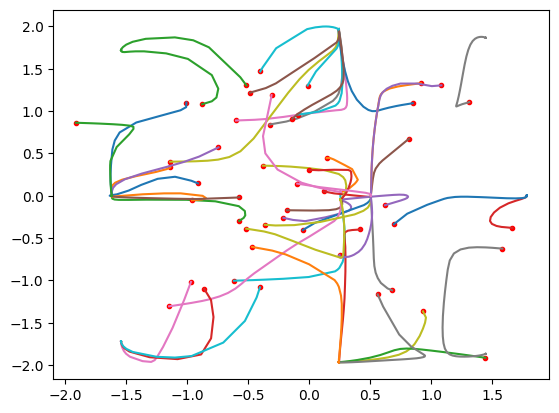

In [232]:
sample_size = 50
for i in range(sample_size):


    P0 = 2 * np.random.rand((8)) - 1


    solution = solve_ivp(neg_grad, (0, 5), P0,     events=get_convergence_event(0.001))#, method='Radau')

    charR, charS = get_characters(solution.y)
    plt.plot(charR[0], charS[0], 'ro', markersize=3)
    
    plt.plot(charR, charS)
   
    # get R, S 
    R, S = get_matrices(solution.y, -1)
    #print(f"Loss of  {i}-th sample: ", "Irr: ",Lirr(R, S, n), "Rel: ", Lrel(R,S,n), "Unitary: ", Lunitary(R,S) ,"Ort: ", ort(R,S))
plt.show()

# Adaptivna dimenzija
Definiramo lahko funkcijo izgube, ki izbira med različnimi dimenzijami.

In [ ]:
def Loss_adaptive_dim(R, S,n):
    return Lirr(R, S, n) + Lrel(R,S,n) + Lunitary(R,S)